# Question 1

Useful inputs.

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

Import digits and plot some examples before and after adding the noise.

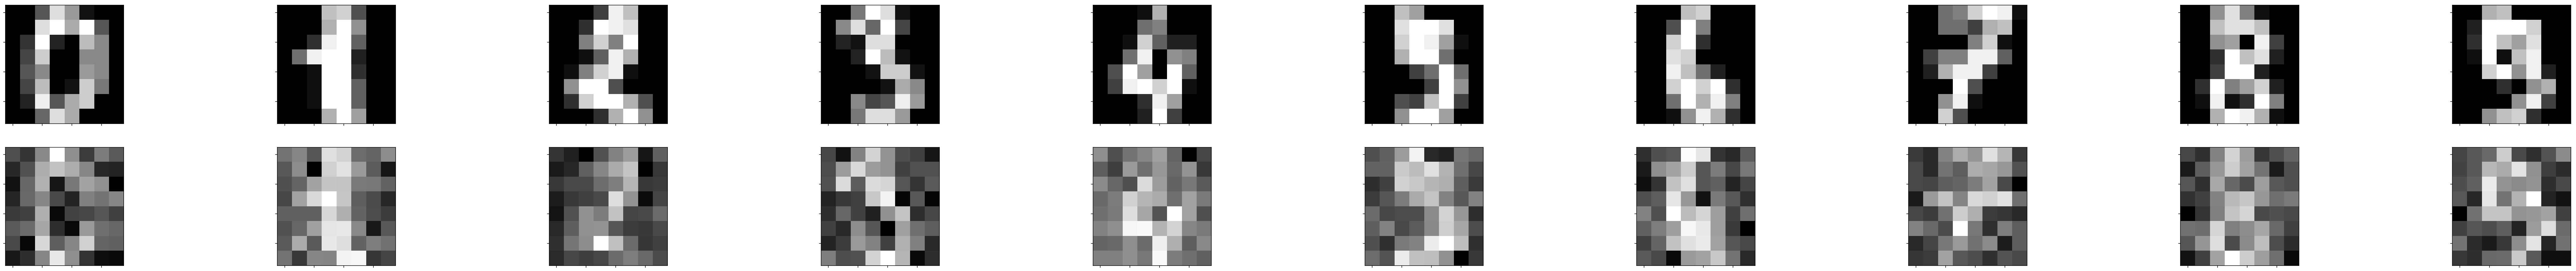

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
digits = digits.data

# fluctuate each pixel's intensity by drawing from a gaussian
# with mean equal to the pixels value and std=4
np.random.seed(42)
noisy = np.random.normal(digits, 4)

fig, axs = plt.subplots(2, 10, figsize=(10 * 8, 8))
for i in range(10):
    # original
    ax = axs[0, i]
    ax.imshow(digits[i].reshape(8, 8), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # with noise
    ax = axs[1, i]
    ax.imshow(noisy[i].reshape(8, 8), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

Reduce digits to a lower number of components.

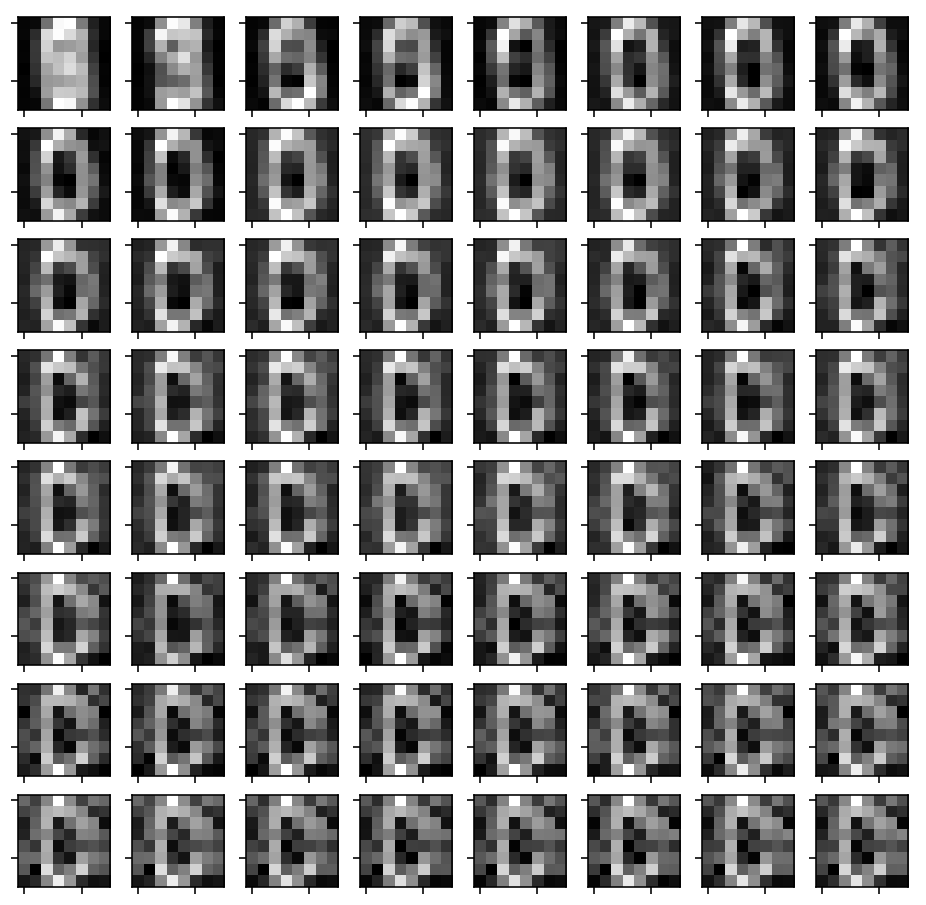

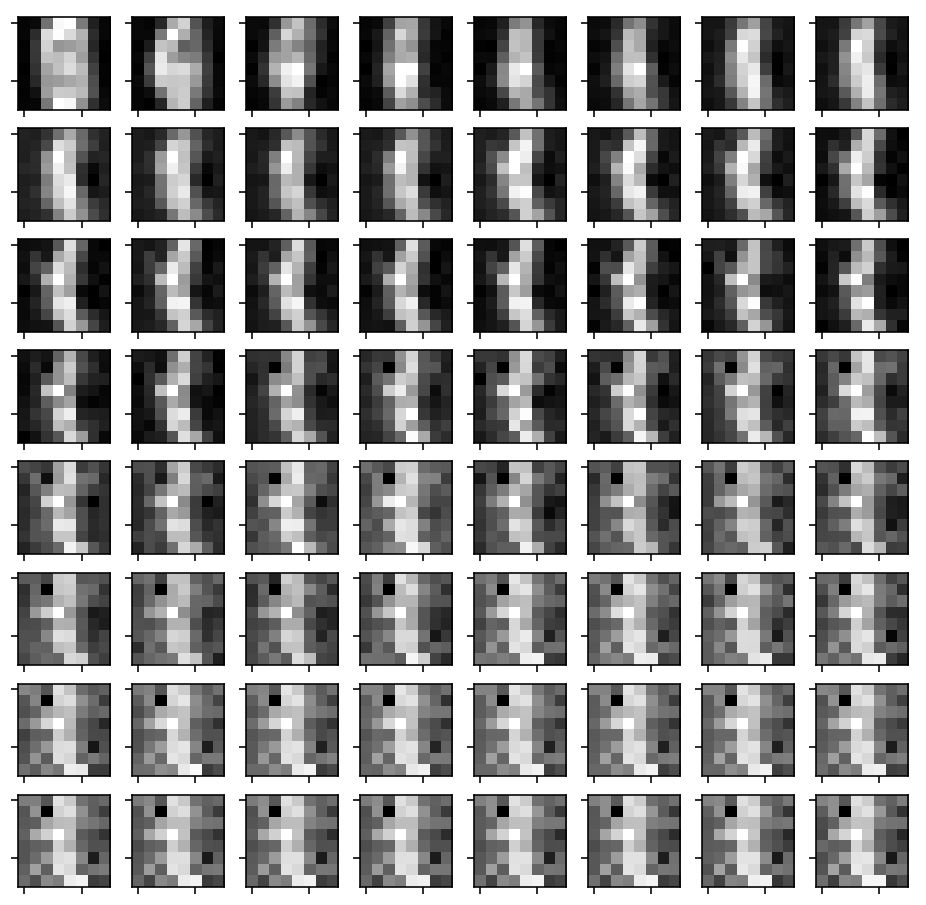

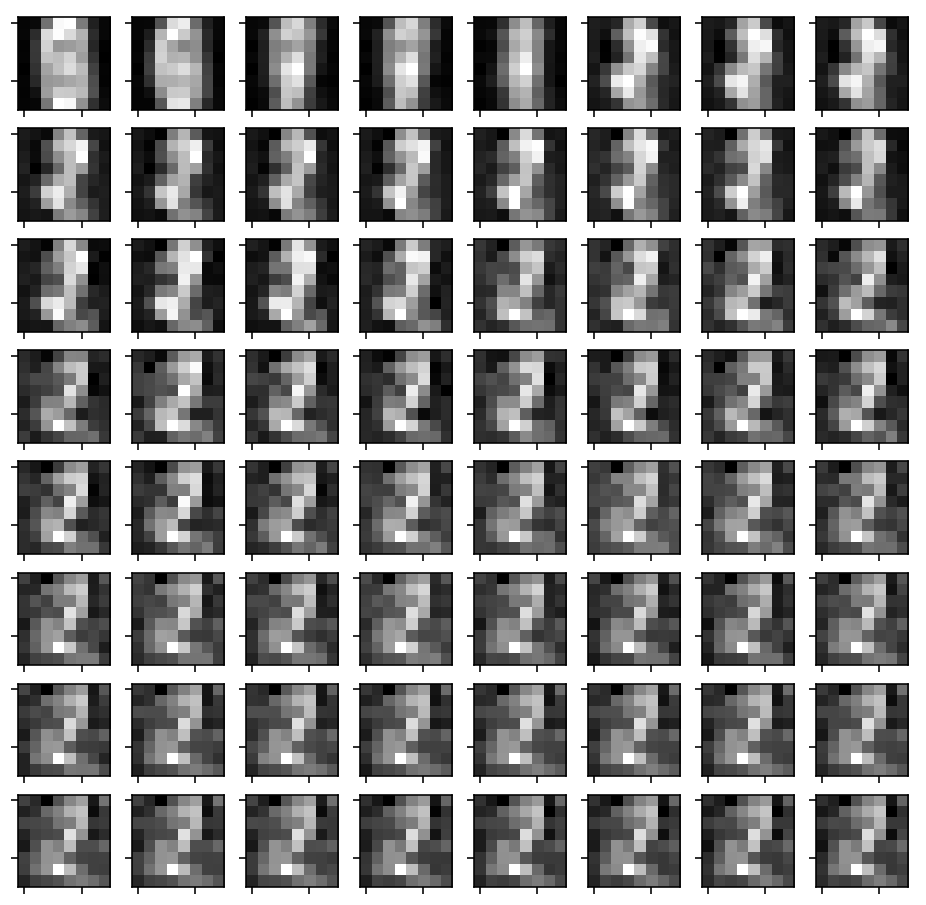

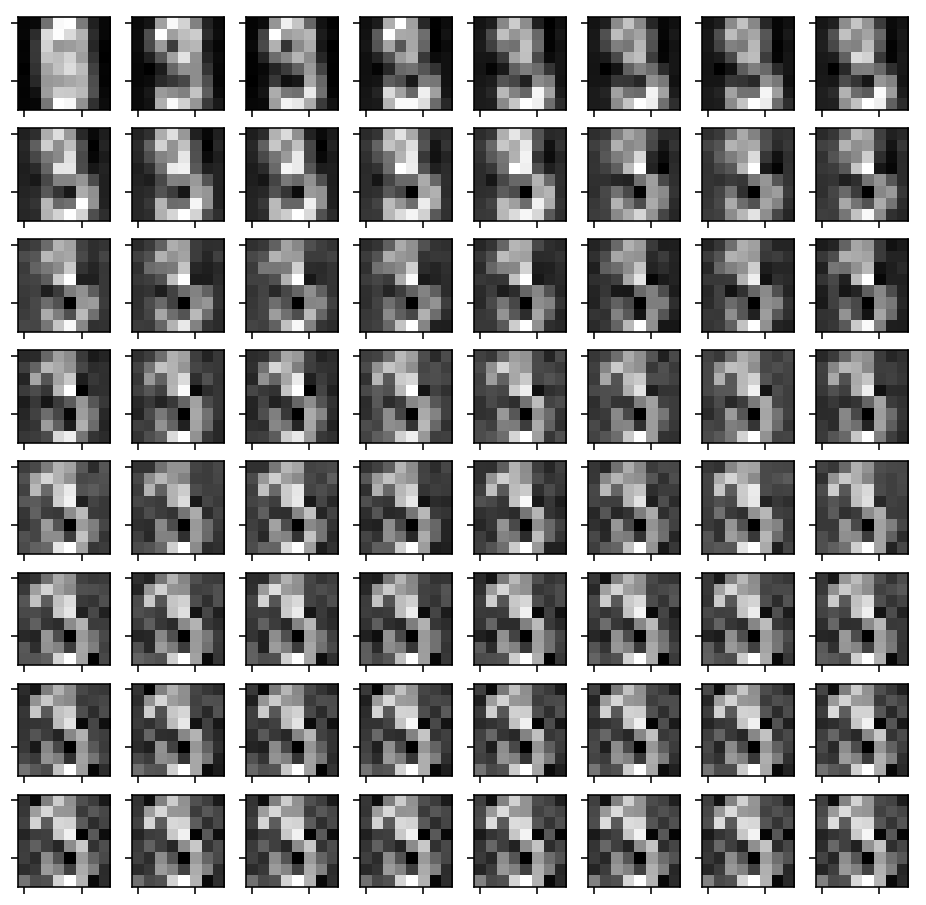

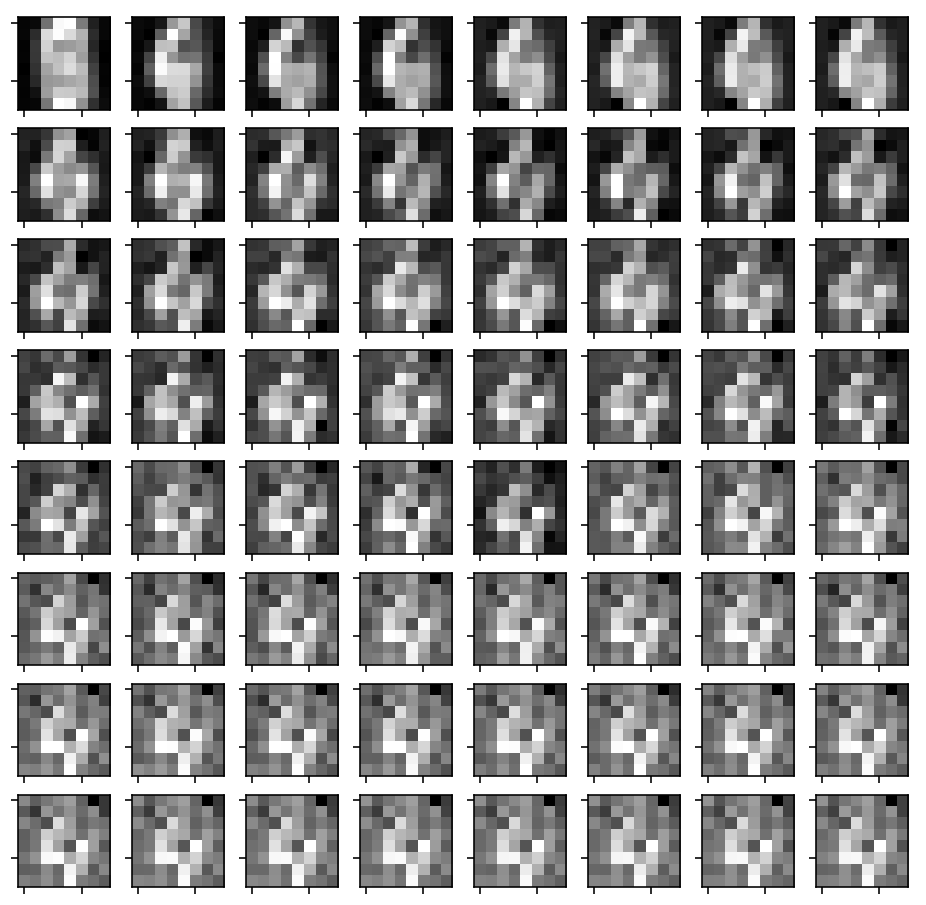

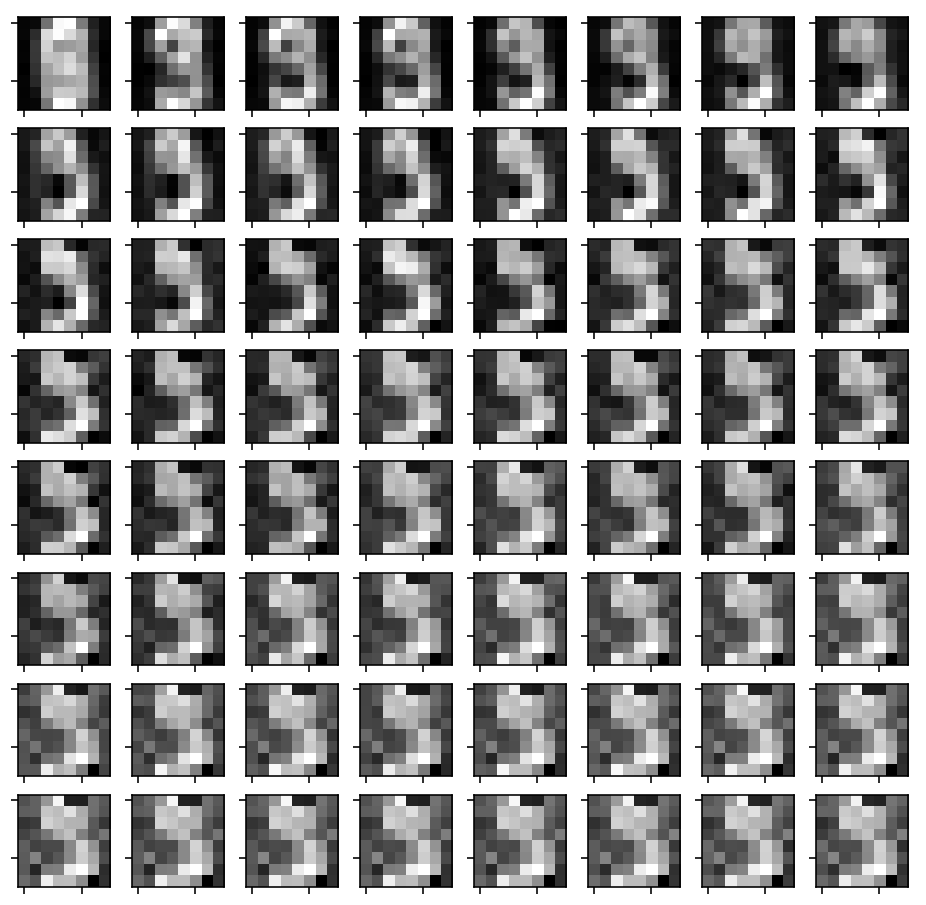

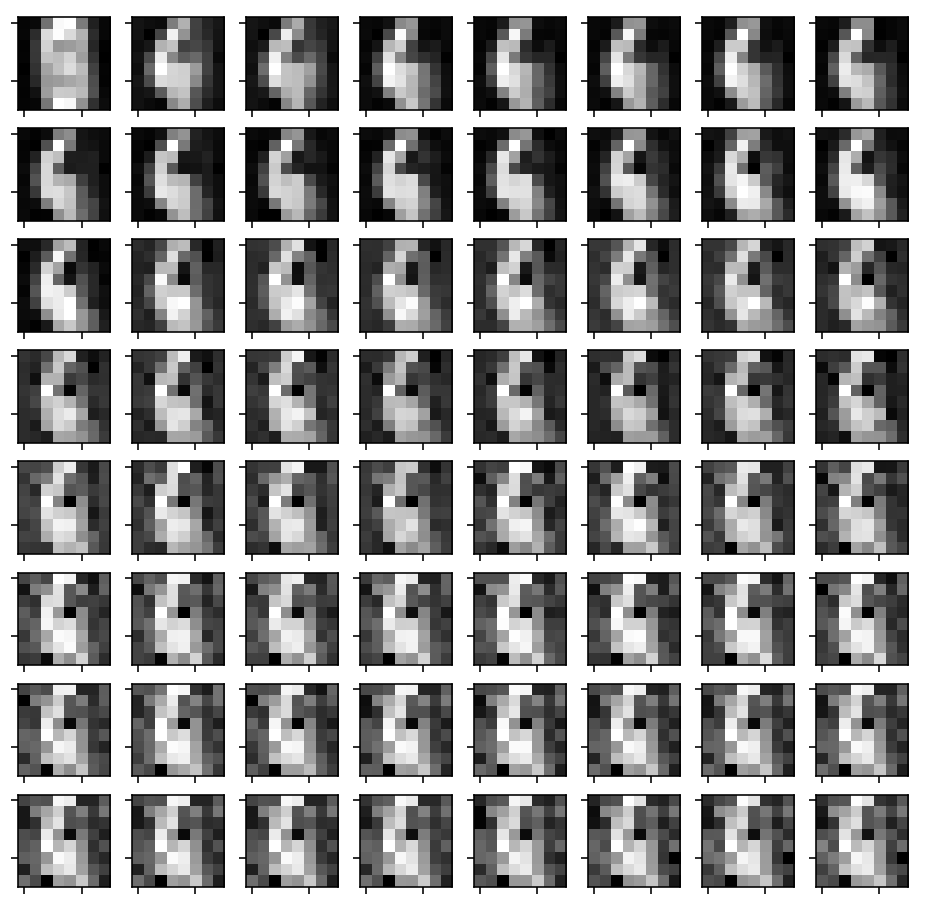

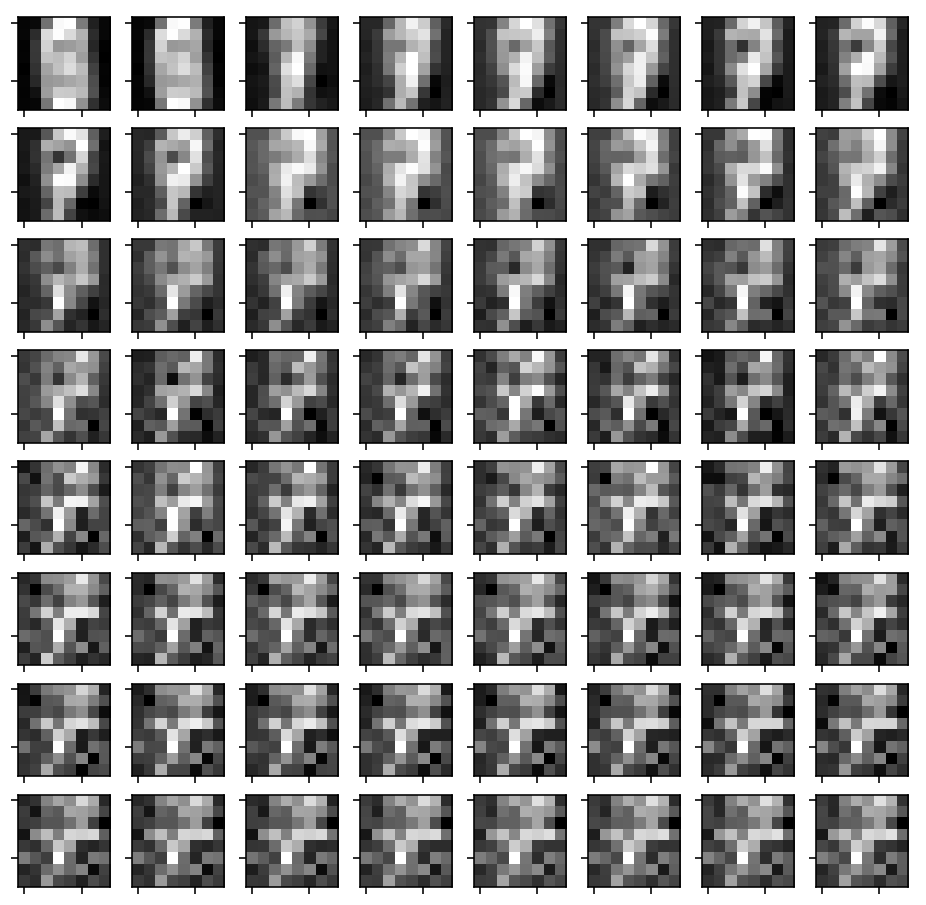

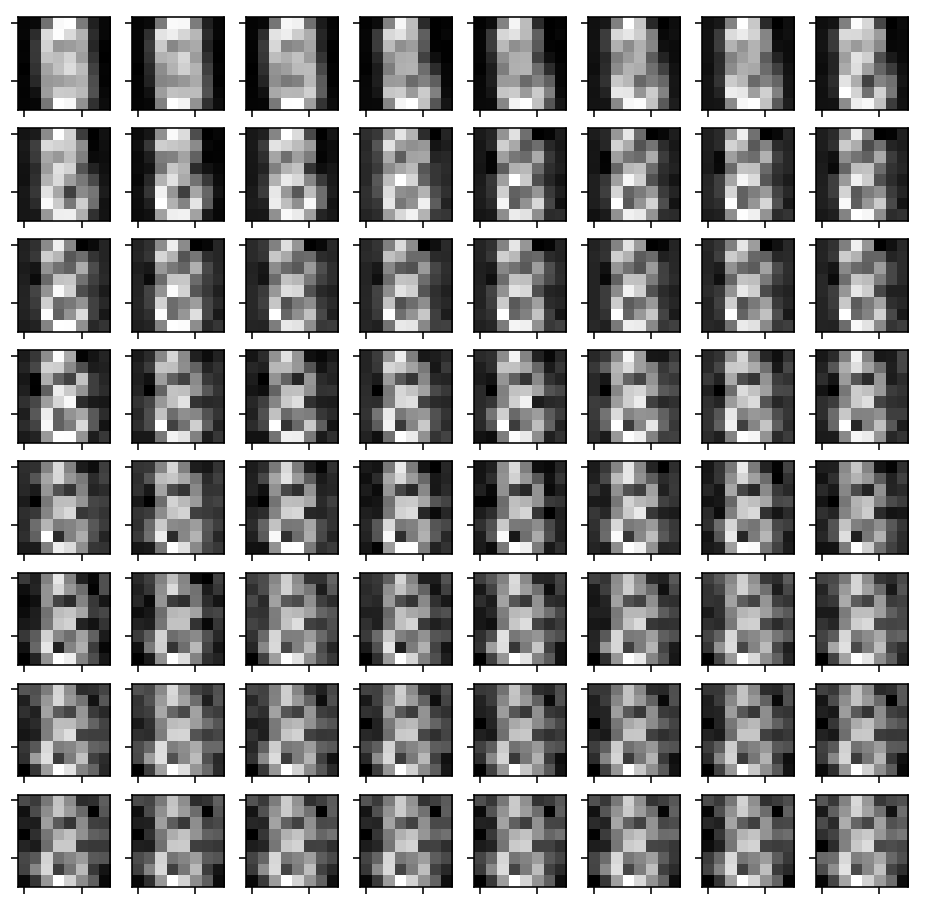

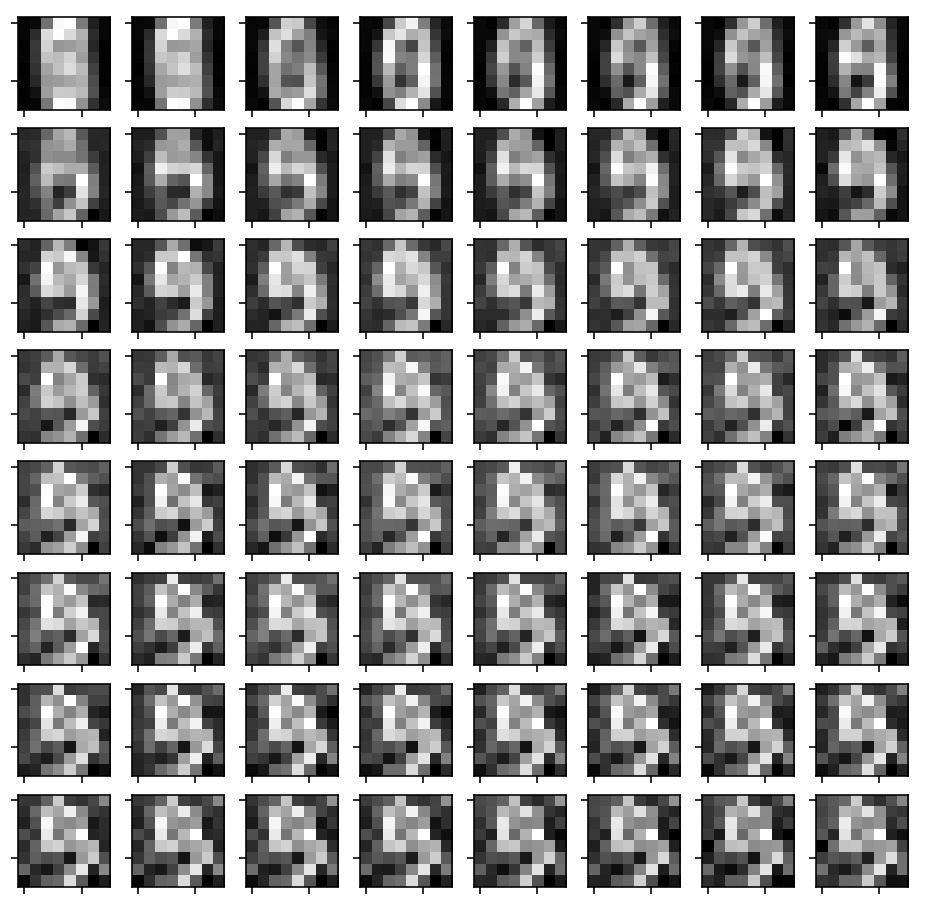

In [39]:
from sklearn.decomposition import PCA

noisy_filt = []
for comps in range(0,64,1):
    pca = PCA(comps)
    pca.fit(noisy)
    noisy_new = pca.transform(noisy)
    noisy_filt.append( pca.inverse_transform(noisy_new) )   

for digit in range(10):
    fig, axs = plt.subplots(8, 8)
    dim=0
    for x in range(8):
        for y in range(8):
            ax = axs[x, y]
            ax.imshow(noisy_filt[dim][digit].reshape(8, 8), cmap='gray')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            dim = dim+1

Naively ("by eye"), the best number of dimensions to filter the noisy digits is comprised between 10 and 20, depending on the digit. With less components we miss too many details, whereas with more components we start to include noise back in.

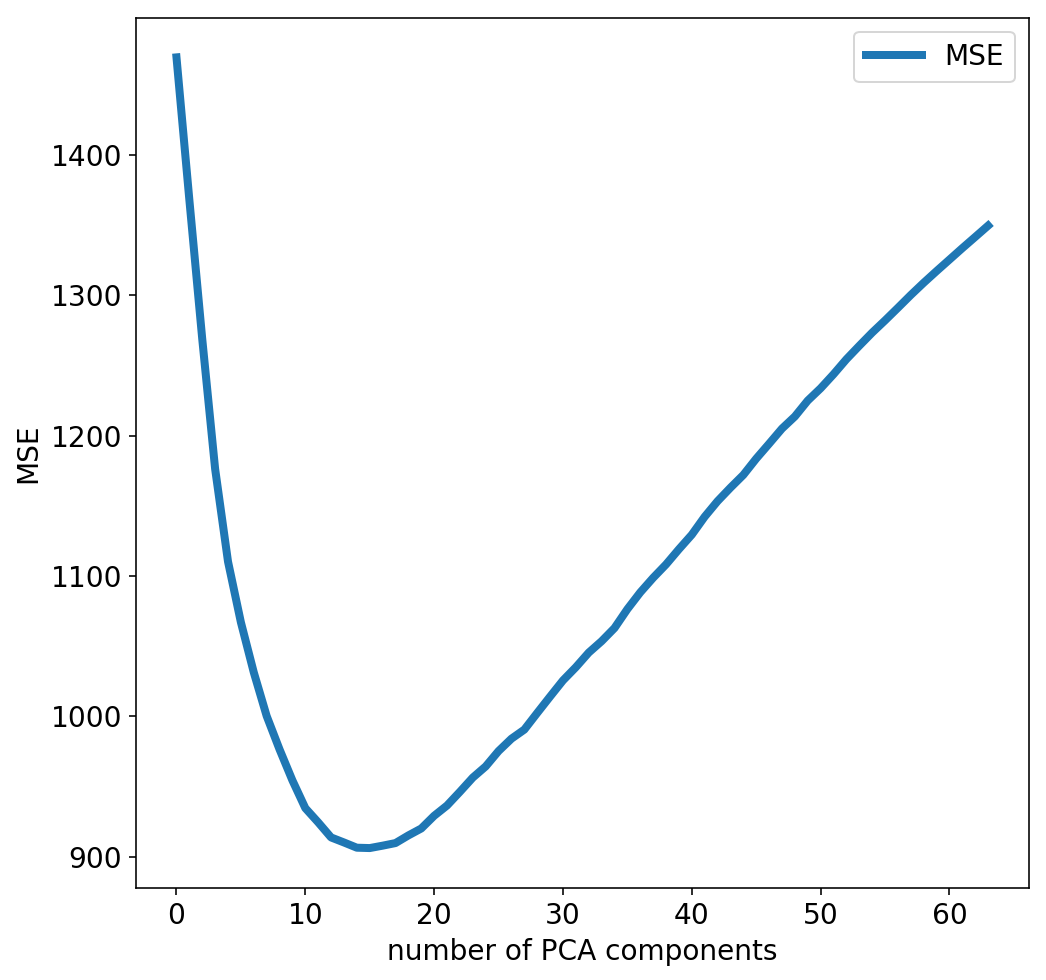

In [43]:
mse = []
comps = np.arange(0,64,1)
for n_comps in range(0,64,1):
    pca = PCA(n_comps)
    pca.fit(noisy)
    noisy_new = pca.transform(noisy)
    noisy_filt = pca.inverse_transform(noisy_new)
    sq_diff = (digits - noisy_filt)*(digits - noisy_filt)
    mse.append( np.sqrt( np.sum( sq_diff.flatten() ) ) )
plt.plot(comps, mse, label='MSE', lw=4)
plt.xlabel('number of PCA components')
plt.ylabel('MSE')
plt.legend(loc='best');

Quantitavely, the best number of componenst can be found by computing the "mean squared error" as the difference between the original digit without noise and the filtered digit. Then, one has to select the number of components which minimizes this error. In our case the best point is around 15.

## Question 2 

Generate and plot toy dataset.

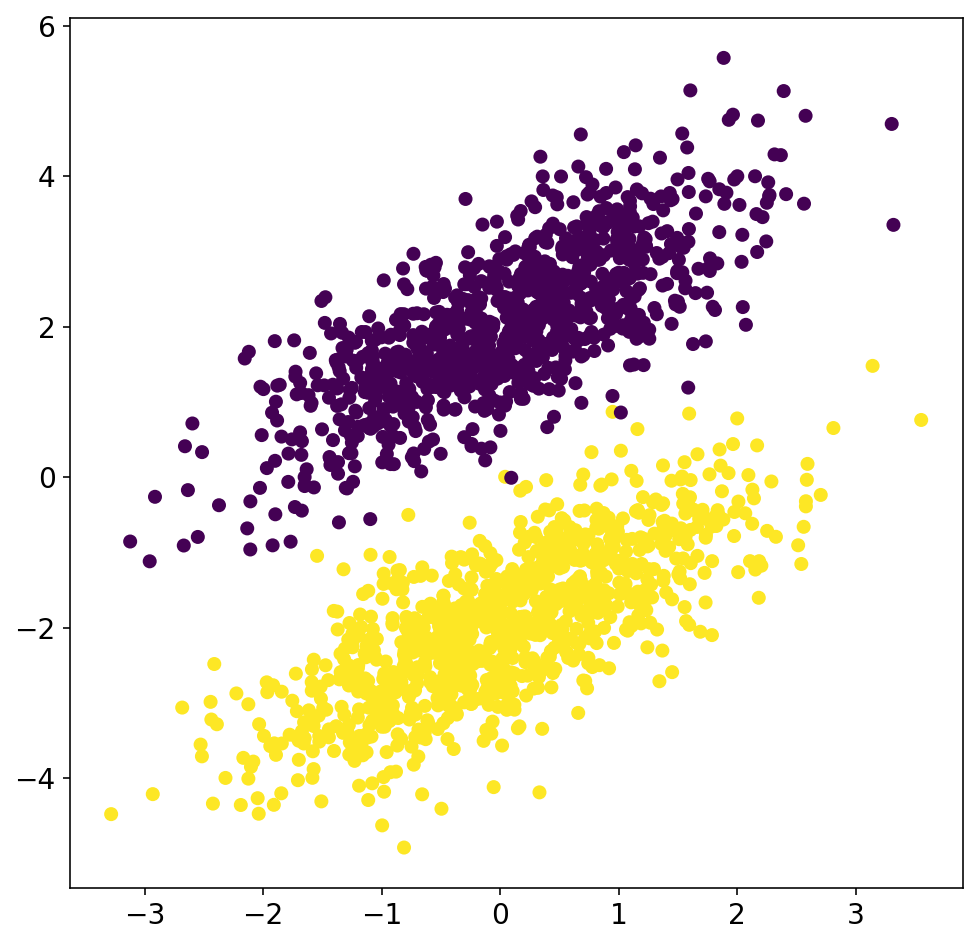

In [51]:
N = 1000
m1 = (1,1)
m2 = (1,4)
C = ((1,0.75), (0.75,1))
g1 = np.random.multivariate_normal((0, -2), C, N)
g2 = np.random.multivariate_normal((0, +2), C, N)

X = np.vstack((g1, g2))
y = np.hstack((np.ones(N), np.zeros(N)))

plt.scatter(X[:,0], X[:,1], c=y);

Find and plot PCA components.

[[ 0.18024949  0.98362092]
 [ 0.98362092 -0.18024949]]
[ 5.13318115  0.85726327]


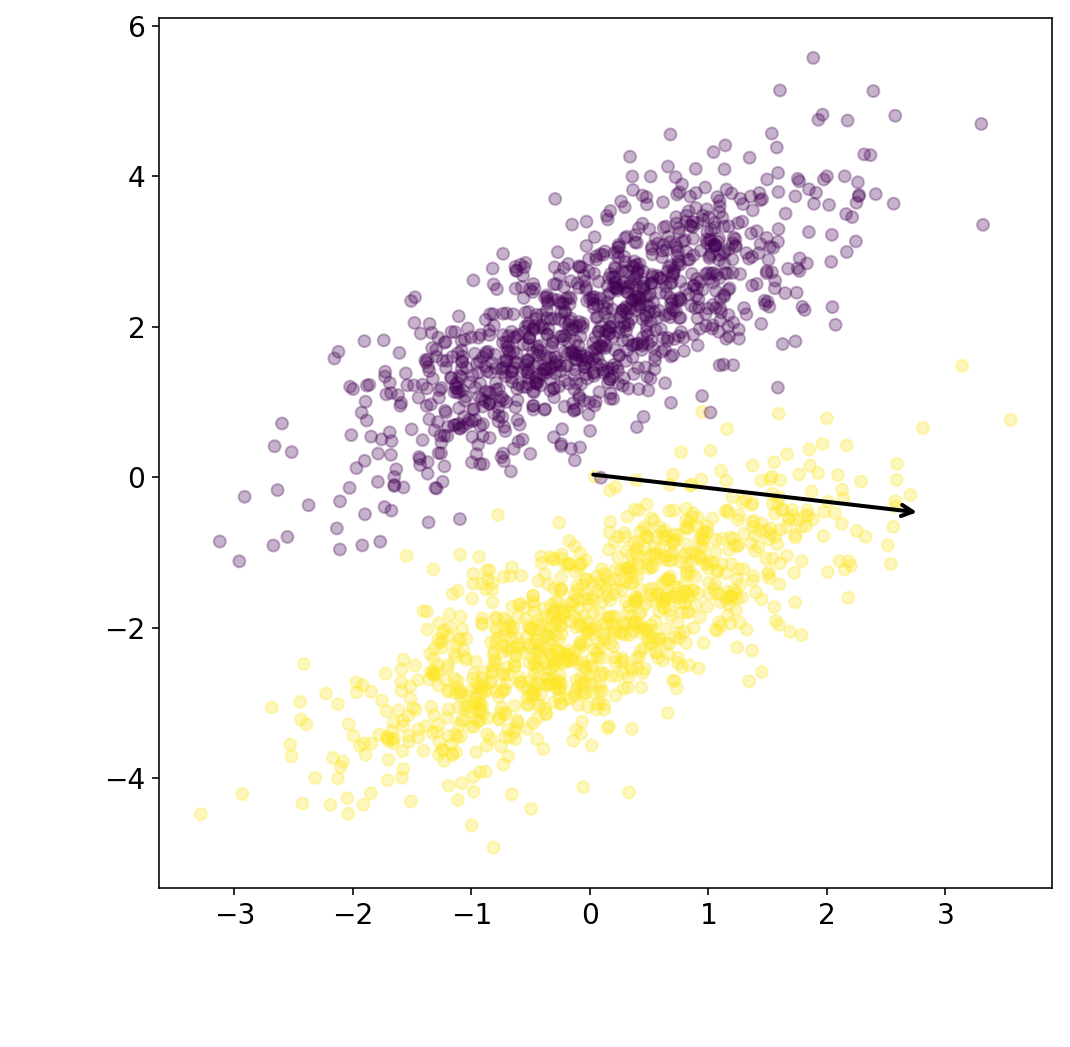

In [62]:
pca = PCA(2)
pca.fit(X)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

plt.scatter(X[:, 0], X[:, 1], alpha=0.3, c=y)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
print(pca.components_)
print(pca.explained_variance_)

Reduce dimensionality.

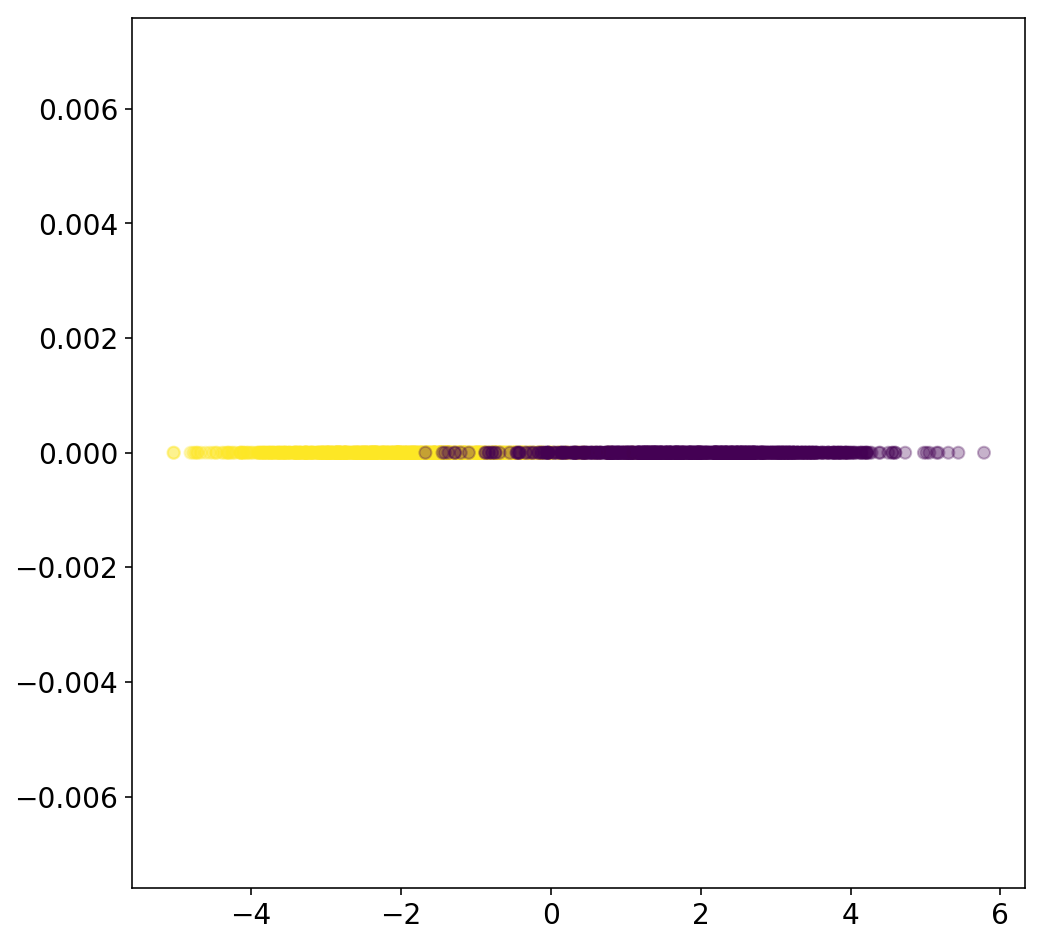

In [65]:
pca = PCA(1)
pca.fit(X)
X_pca = pca.transform(X)
plt.scatter(X_pca[:,0], [0]*len(y), alpha=0.3, c=y);

Solve problem with a LDA.

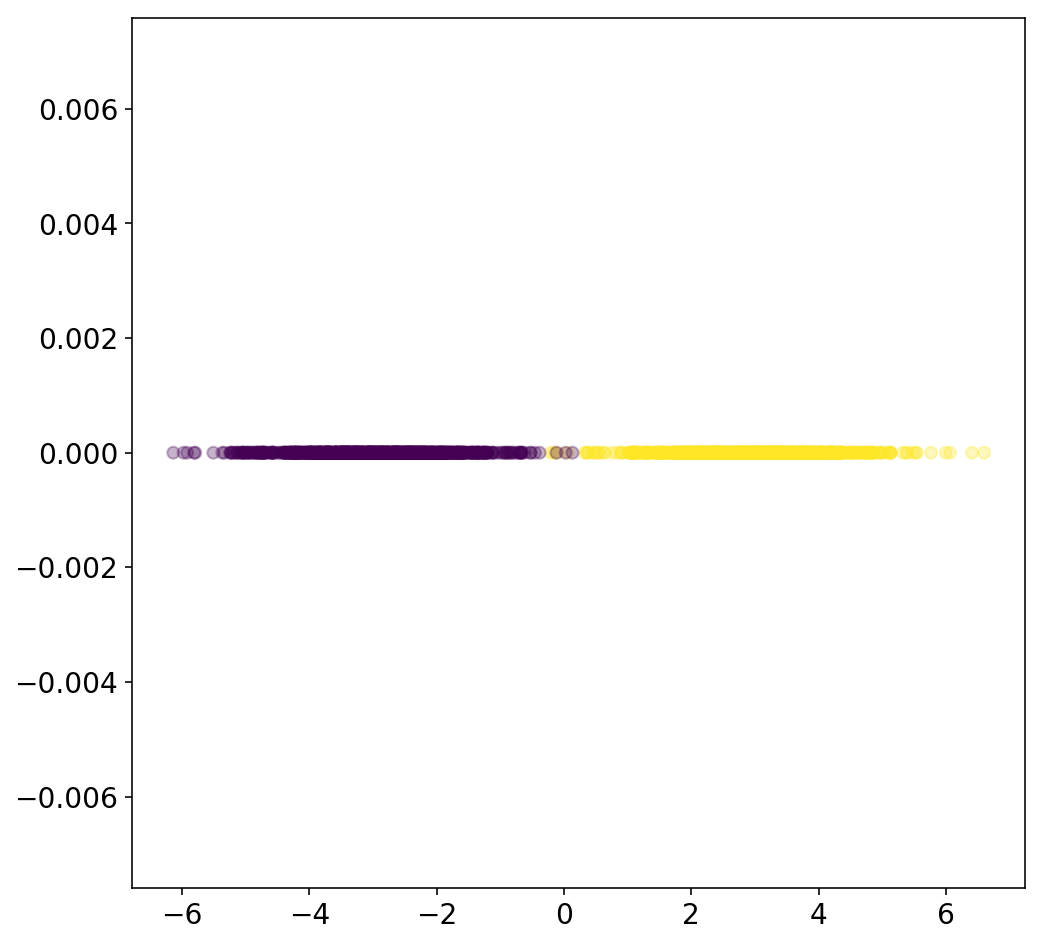

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
X_lda = lda.transform(X)
plt.scatter(X_lda[:,0], [0]*len(y), alpha=0.3, c=y);

The LDA allows a better separation of the two classes, because it looks for the maximum variance between classes. The PCA only looks for the maximum variance of the unlabeled dataset.

## Question 3 

Import MNIST digit dataset.

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
np.random.seed(42)

# loading the MNIST (or digits) dataset in keras
from keras.datasets import mnist

(x_train, y_train), (_, _) = mnist.load_data()
X = x_train / 255

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_train,
                                                    train_size=0.8, random_state=1)

from keras.utils import np_utils
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Create noisy dataset.

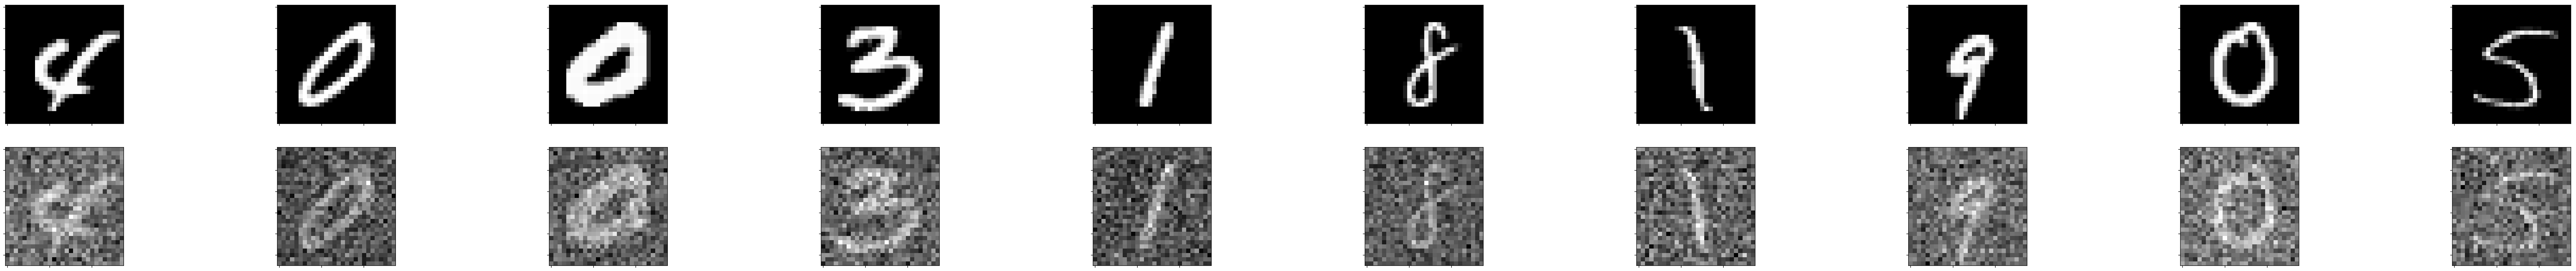

In [12]:
# fluctuate each pixel's intensity by drawing from a gaussian
# with mean equal to the pixels value and std=0.4
np.random.seed(42)
X_train_noisy = np.random.normal(X_train, 0.4)
X_test_noisy = np.random.normal(X_test, 0.4)

fig, axs = plt.subplots(2, 10, figsize=(10 * 8, 8))
for i in range(10):
    # original
    ax = axs[0, i]
    ax.imshow(X_train[i+42].reshape(28,28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # after noise addition
    ax = axs[1, i]
    ax.imshow(X_train_noisy[i+42].reshape(28,28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

Build Auto Encoder.

In [31]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

input_img = Input(shape=(28,28,1,))

encoded = Dense(units=64,
                input_shape=(28,28,1,), 
                activation='relu',
                kernel_initializer='random_uniform',
                bias_initializer='zeros')(input_img)

conv = Conv2D(4, (3, 3), 
              use_bias=True,
              activation='relu',
              kernel_initializer='random_uniform',
              bias_initializer='zeros')(encoded)

flat = Flatten()(conv)

reduced = Dense(32, 
               activation='relu',
               kernel_initializer='random_uniform',
               bias_initializer='zeros')(flat)

decoded = Dense(28*28, 
                activation='relu',
                kernel_initializer='random_uniform',
                bias_initializer='zeros')(reduced)

reshape = Reshape( (28, 28, 1, ) )(decoded)

autoencoder = Model(input_img, reshape)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
dense_30 (Dense)             (None, 28, 28, 64)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 4)         2308      
_________________________________________________________________
flatten_5 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                86560     
_________________________________________________________________
dense_32 (Dense)             (None, 784)               25872     
_________________________________________________________________
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
Total para

In [32]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

model = autoencoder.fit(X_train_noisy, X_train,
                        epochs=10,
                        batch_size=256,
                        shuffle=True,
                        verbose=True,
                        validation_data=(X_test_noisy, X_test))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 368s - loss: 0.0604 - val_loss: 0.0348
Epoch 2/10
48000/48000 [==============================] - 284s - loss: 0.0298 - val_loss: 0.0273
Epoch 3/10
48000/48000 [==============================] - 275s - loss: 0.0267 - val_loss: 0.0262
Epoch 4/10
48000/48000 [==============================] - 245s - loss: 0.0260 - val_loss: 0.0259
Epoch 5/10
48000/48000 [==============================] - 281s - loss: 0.0257 - val_loss: 0.0257
Epoch 6/10
48000/48000 [==============================] - 293s - loss: 0.0253 - val_loss: 0.0252
Epoch 7/10
48000/48000 [==============================] - 291s - loss: 0.0250 - val_loss: 0.0250
Epoch 8/10
48000/48000 [==============================] - 337s - loss: 0.0248 - val_loss: 0.0248
Epoch 9/10
48000/48000 [==============================] - 327s - loss: 0.0246 - val_loss: 0.0246
Epoch 10/10
48000/48000 [==============================] - 311s - loss: 0.024